__Copyright 2017 Igor Vustianiuk__

In [143]:
%matplotlib inline
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import pywt
from skimage import color
from skimage import io

In [144]:
def fourier_linear(ftimage, r):
    Z = np.zeros((ftimage.shape), dtype=complex)
    for i in range(255-r+1, 256+r):
        for j in range(255-r+1, 256+r):
            Z[i,j] = ftimage[i,j]
    return np.fft.ifftshift(Z)


def fourier_nonlinear(ftimage, thresh):
    (nr, nc) = image.shape
    for i in range(nc):
        for j in range(nr):
            if np.abs(ftimage[i,j]) <= thresh:
                ftimage[i,j] = 0
    return np.fft.ifftshift(ftimage)


def haar_linear(coeffs):
    new_coeffs = copy.deepcopy(coeffs)
    n = len(new_coeffs) - 1
    for i in range(1, n+1):
        for j in range(3):
            tmp = new_coeffs[i][j]
            prev = copy.deepcopy(tmp)
            tmp.fill(0)
    return new_coeffs


def haar_nonlinear(coeffs, theta):
    new_coeffs = copy.deepcopy(coeffs)
    n = len(new_coeffs) - 1
    tmp = new_coeffs[0]
    Ix = np.abs(tmp) < theta
    tmp[Ix] = np.zeros(tmp[Ix].shape)
    for i in range(n+1):
        for j in range(3):
            tmp = new_coeffs[i][j]
            Ix = np.abs(tmp) < theta
            tmp[Ix] = np.zeros(tmp[Ix].shape)
    return new_coeffs


# Mean Squared Error
def mse(A, B):
    return np.mean(np.abs(A - B)**2)


# Peak Signal to Noise Ration
def psnr(A, B):
    return 10 * np.log10(1 / mse(A, B))

In [145]:
image = mpimg.imread('barbara.png')


def show_original_image():
    plt.figure(figsize = (4.5, 4.5))
    plt.imshow(np.abs(image), cmap='gray')
    plt.axis('off')
    plt.title('Original image')
    plt.show()

In [146]:
def fourier_compare_auxilary(r, dict_data, verbose = False):
    ftimage = np.fft.fft2(image)
    ftimage = np.fft.fftshift(ftimage)
    
    (nr, nc) = image.shape
    alpha_linear = 100 * (1 - 4*r*r/(nr*nc))
    theta = np.percentile(np.abs(ftimage), alpha_linear)
    ftimagep_linear = fourier_linear(ftimage, r=r)
    ftimagep_nonlinear = fourier_nonlinear(ftimage, thresh=theta)
    alpha_nonlinear = 100 * (nr*nc - np.count_nonzero(ftimagep_nonlinear)) / (nr*nc)
    
    img_linear = np.fft.ifft2(ftimagep_linear)
    img_nonlinear = np.fft.ifft2(ftimagep_nonlinear)
    
    psnr_linear = psnr(image, img_linear)
    psnr_nonlinear = psnr(image, img_nonlinear)
    
    if verbose:
        print('r =', r, end =';  ')
        print('alpha_linear: ', alpha_linear, end = ';  ')
        print('theta: ', theta, end = ';  ')
        print('alpha_nonlinear: ', alpha_nonlinear)
        print('psnr_linear: ', psnr_linear, end = ';  ')
        print('psnr_nonlinear: ', psnr_nonlinear)
    
    dict_data['r'].append(r)
    dict_data['psnr_linear'].append(psnr_linear)
    dict_data['psnr_nonlinear'].append(psnr_nonlinear)
    
    fig, ax = plt.subplots(1, 2, figsize=(10,20))
    ax[0].imshow(np.abs(img_linear), cmap='gray')
    ax[0].set_title('Linear, r = {}'.format(r))
    ax[0].axis('off')
    ax[1].imshow(np.abs(img_nonlinear), cmap='gray')
    ax[1].set_title('Nonlinear, r = {}'.format(r))
    ax[1].axis('off')
    plt.show()

In [158]:
def haar_compare_auxilary(n, dict_data, verbose = False):
    def make_it_flat(t):
        ans = t[0].flatten()
        for i in range(1, len(t)):
            for j in range(3):
                ans = np.concatenate((ans, t[i][j].flatten()))
        return ans

    
    coeffs = pywt.wavedec2(image, 'haar', level = n)

    coeffs_linear = haar_linear(coeffs)
    (nr, nc) = image.shape
    (r, c) = coeffs[0].shape
    alpha_linear = 100 * (1 - r*c/(nr*nc))
    coeffs_array = make_it_flat(coeffs)
    theta = np.percentile(coeffs_array, alpha_linear)
    coeffs_nonlinear = haar_nonlinear(coeffs, theta)
    alpha_nonlinear = 100 * (nr*nc - np.count_nonzero(make_it_flat(coeffs_nonlinear))) / (nr*nc)
    
    img_linear = pywt.waverec2(coeffs_linear, 'haar')
    img_nonlinear = pywt.waverec2(coeffs_nonlinear, 'haar')
    
    psnr_linear = psnr(image, img_linear)
    psnr_nonlinear = psnr(image, img_nonlinear)
    
    if verbose:
        print('n =', n, end =';  ')
        print('alpha_linear: ', alpha_linear, end = ';  ')
        print('theta: ', theta, end = ';  ')
        print('alpha_nonlinear: ', alpha_nonlinear)
        print('psnr_linear: ', psnr_linear, end = ';  ')
        print('psnr_nonlinear: ', psnr_nonlinear)
    
    dict_data['n'].append(n)
    dict_data['psnr_linear'].append(psnr_linear)
    dict_data['psnr_nonlinear'].append(psnr_nonlinear)
    
    fig, ax = plt.subplots(1, 2, figsize=(10,20))
    ax[0].imshow(np.abs(img_linear), cmap='gray')
    ax[0].set_title('Linear, r = {}'.format(r))
    ax[0].axis('off')
    ax[1].imshow(np.abs(img_nonlinear), cmap='gray')
    ax[1].set_title('Nonlinear, r = {}'.format(r))
    ax[1].axis('off')
    plt.show()

In [159]:
def fourier_compare():
    show_original_image()
    dict_fourier = {'r': [], 'psnr_linear': [], 'psnr_nonlinear': []}
    for r in [50, 100, 150, 200, 250]:
        fourier_compare_auxilary(r, dict_fourier)
    table_fourier = pd.DataFrame(dict_fourier)
    table_fourier.set_index('r', inplace=True)

    print('Linear and nonlinear approximation (Fourier)')
    from IPython.display import display, HTML
    display(HTML(table_fourier.to_html()))
    #print(table_fourier)
    #return table_fourier


def haar_compare():
    show_original_image()
    dict_haar = {'n': [], 'psnr_linear': [], 'psnr_nonlinear': []}
    for n in range(1, 6):
        haar_compare_auxilary(n, dict_haar)
    table_haar = pd.DataFrame(dict_haar)
    table_haar.set_index('n', inplace=True)

    print('Linear and nonlinear approximation (Haar)')
    from IPython.display import display, HTML
    display(HTML(table_haar.to_html()))
    #print(table_haar)
    #return table_haar

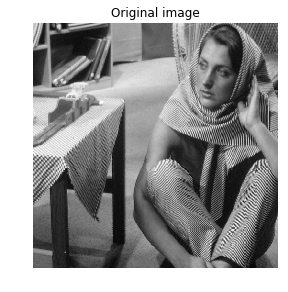

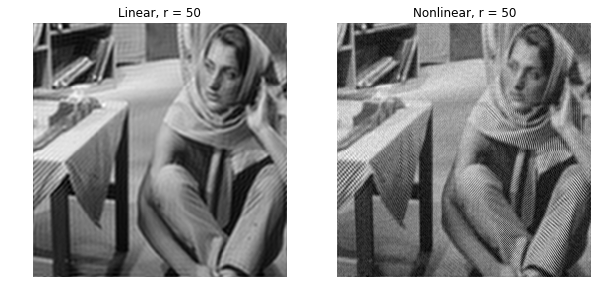

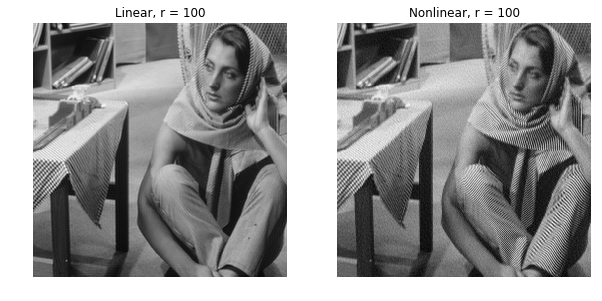

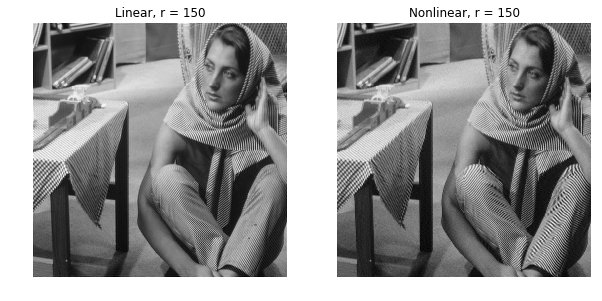

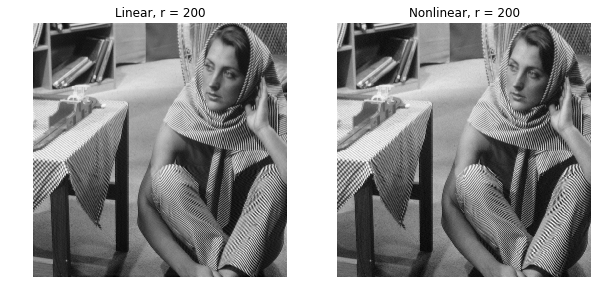

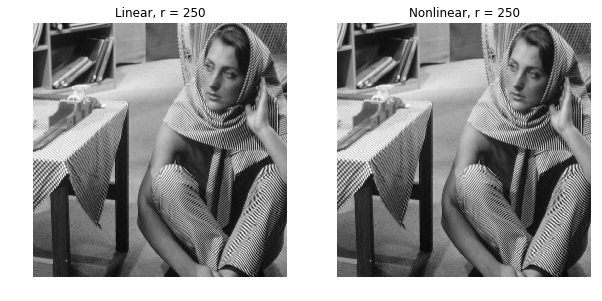

Linear and nonlinear approximation (Fourier)


,psnr_linear,psnr_nonlinear
r,,
50,23.327421,24.977117
100,24.623913,29.830790
150,27.475110,35.945529
200,34.509873,44.347737
250,52.106808,70.193886


In [160]:
fourier_compare()

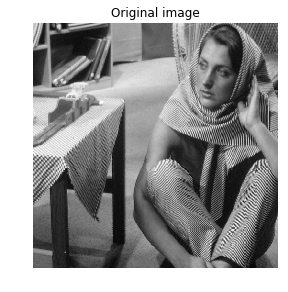

n =  1;  alpha_linear:  75.0;  theta:  0.23137253522872925;  alpha_nonlinear:  74.517822265625
psnr_linear:  25.415425804468875;  psnr_nonlinear:  26.76219346113376


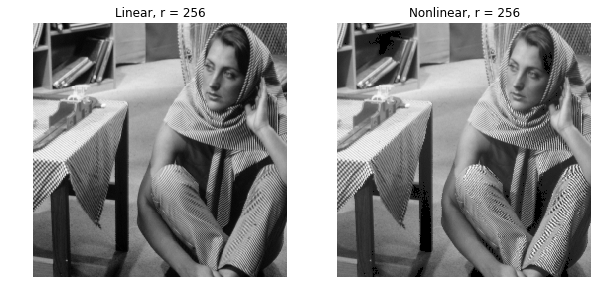

n =  2;  alpha_linear:  93.75;  theta:  0.4549019057303667;  alpha_nonlinear:  93.6614990234375
psnr_linear:  22.91574882701855;  psnr_nonlinear:  23.24589910023859


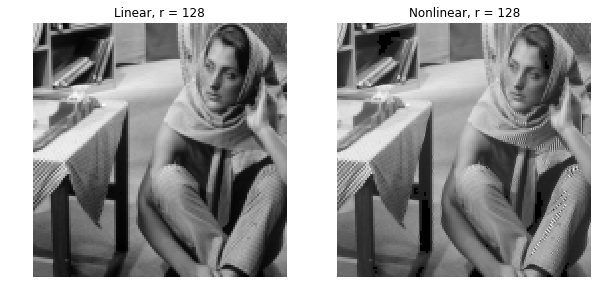

n =  3;  alpha_linear:  98.4375;  theta:  0.9309205133467913;  alpha_nonlinear:  98.40660095214844
psnr_linear:  21.148192591959024;  psnr_nonlinear:  21.521443880617994


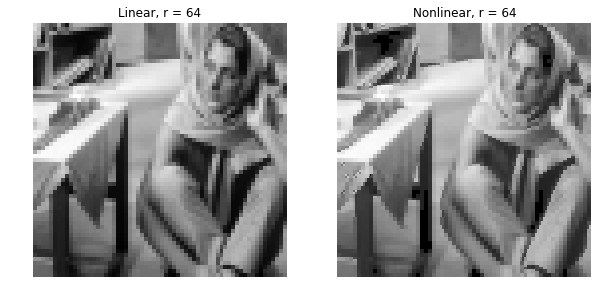

n =  4;  alpha_linear:  99.609375;  theta:  2.083340674638748;  alpha_nonlinear:  99.59983825683594
psnr_linear:  19.185998528550073;  psnr_nonlinear:  19.523211909972268


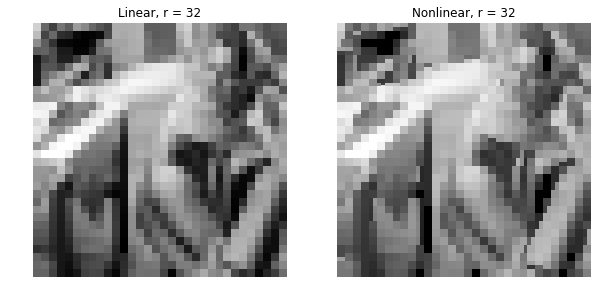

n =  5;  alpha_linear:  99.90234375;  theta:  4.867906037252396;  alpha_nonlinear:  99.90196228027344
psnr_linear:  17.337448174209978;  psnr_nonlinear:  17.38931192727971


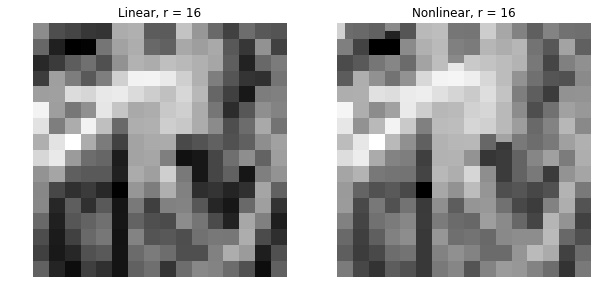

Linear and nonlinear approximation (Haar)


,psnr_linear,psnr_nonlinear
n,,
1,25.415426,26.762193
2,22.915749,23.245899
3,21.148193,21.521444
4,19.185999,19.523212
5,17.337448,17.389312


In [157]:
haar_compare()